In [1]:
import os
import glob
import h5py       
import numpy as np
import matplotlib.pyplot as plt
import torch

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["image.origin"] = "lower"  

In [2]:
DATA_DIR = r"C:\Work\College\DeepONets\wave_first"

PATTERN = "*.mat"

mat_files = sorted(glob.glob(os.path.join(DATA_DIR, PATTERN)))

file = mat_files[0]


In [3]:
with h5py.File(file, "r") as f:
    top_keys = list(f.keys())
    print(top_keys)
    
    for key in ["t_out", "x", "U_out"]:
        if key in f:
            dset = f[key]
            print(f"{key}: shape={dset.shape}, dtype={dset.dtype}")
        else:
            print(f"{key} not found at top level.")


['U_out', 't_out', 'x']
t_out: shape=(8276, 1), dtype=float64
x: shape=(5120, 1), dtype=float64
U_out: shape=(5120, 8276), dtype=[('real', '<f8'), ('imag', '<f8')]


In [4]:
# Wave Loader

def load_wave_mat_v73(filepath, t_key="t_out", x_key="x", U_key="U_out"):
    print(f"\nLoading file: {filepath}")
    with h5py.File(filepath, "r") as f:
        if t_key not in f or x_key not in f or U_key not in f:
            raise KeyError(f"One of the keys ({t_key}, {x_key}, {U_key}) not found in the file.")
        
        t = np.array(f[t_key]).squeeze()
        x = np.array(f[x_key]).squeeze()
        U_raw = np.array(f[U_key])

        print(f"  t: shape={t.shape}, dtype={t.dtype}")
        print(f"  x: shape={x.shape}, dtype={x.dtype}")
        print(f"  U_raw: shape={U_raw.shape}, dtype={U_raw.dtype}")

        # Complex Storage Formats
        if U_raw.dtype.fields is not None and "real" in U_raw.dtype.fields and "imag" in U_raw.dtype.fields:
            print("Detected compound dtype with fields ['real', 'imag']. Reconstructing complex U...")
            U = U_raw["real"] + 1j * U_raw["imag"]

        elif np.iscomplexobj(U_raw):
            print("Detected numpy complex array. Using as-is.")
            U = U_raw

        else:
            print("U_out not detected as complex; treating as real-only data.")
            U = U_raw.astype(np.complex128)

        U = np.squeeze(U)
        print(f"  After squeeze: U shape={U.shape}, dtype={U.dtype}")

        # --- Ensure U has shape (T, X) = (len(t), len(x)) ---
        T_expected, X_expected = len(t), len(x)

        # If shape matches (X, T), transpose it
        if U.shape == (X_expected, T_expected):
            print(" Transposing U from (X, T) to (T, X) to match (t, x).")
            U = U.T

        # Final sanity check
        if U.shape != (T_expected, X_expected):
            raise ValueError(
                f"U has shape {U.shape}, but expected ({T_expected}, {X_expected}). "
                "Check dimension ordering or keys."
            )

        print(f"Final U shape={U.shape} (T, X) = ({T_expected}, {X_expected})")
        return t, x, U

print("Loader function defined.")


Loader function defined.


In [5]:
t,x, U = load_wave_mat_v73("C:\Work\College\DeepONets\wave_first\Re_78315_case3_1of160.mat")



Loading file: C:\Work\College\DeepONets\wave_first\Re_78315_case3_1of160.mat
  t: shape=(8276,), dtype=float64
  x: shape=(5120,), dtype=float64
  U_raw: shape=(5120, 8276), dtype=[('real', '<f8'), ('imag', '<f8')]
Detected compound dtype with fields ['real', 'imag']. Reconstructing complex U...
  After squeeze: U shape=(5120, 8276), dtype=complex128
 Transposing U from (X, T) to (T, X) to match (t, x).
Final U shape=(8276, 5120) (T, X) = (8276, 5120)


In [6]:
# Filter data to keep only t >= 200
mask_time = t > 200
t = t[mask_time]
U = U[mask_time, :]

mask_x = (x > 150) & (x < 650)
x = x[mask_x]
U = U[:, mask_x]

# Downsample time
DOWNSAMPLE_FACTOR = 1
t = t[::DOWNSAMPLE_FACTOR]
U = U[::DOWNSAMPLE_FACTOR, :]

print(f"Filtered and downsampled data (DS={DOWNSAMPLE_FACTOR}):")
print(f"  New t shape: {t.shape}")
print(f"  New U shape: {U.shape}")

Filtered and downsampled data (DS=1):
  New t shape: (6586,)
  New U shape: (6586, 3333)


In [7]:
# Load one recording and compute envelope magnitude |U|
print("\nLoaded example recording:")
print("  • t shape:", t.shape)
print("  • x shape:", x.shape)
print("  • U shape:", U.shape, "dtype:", U.dtype)

if t[0] > t[-1]:
    idx = np.argsort(t)
    t = t[idx]
    U = U[idx, :]

# Envelope amplitude
A = np.abs(U)

print("\nEnvelope |U| statistics for this recording:")
print("  • shape:", A.shape)
print("  • min:", A.min())
print("  • max:", A.max())
print("  • mean:", A.mean())
print("  • std :", A.std())



Loaded example recording:
  • t shape: (6586,)
  • x shape: (3333,)
  • U shape: (6586, 3333) dtype: complex128

Envelope |U| statistics for this recording:
  • shape: (6586, 3333)
  • min: 2.711393517932373e-05
  • max: 0.2580013695793466
  • mean: 0.047538147666648004
  • std : 0.026994762997122328


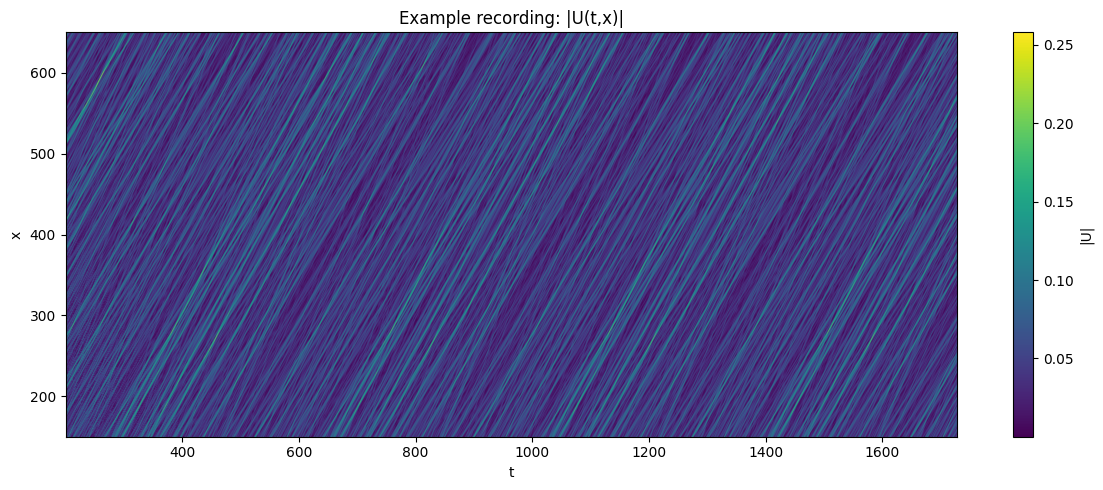

In [8]:
# Visualize the full spatiotemporal envelope |U(t,x)|

def plot_envelope_heatmap(t, x, A, title="|U(x,t)|"):
    """
    (Nt, Nx) = (time, space)
    Horizontal axis: time
    Vertical axis: space
    """
    plt.figure(figsize=(12, 5))

    plt.imshow(
        A.T,                         # (Nx, Nt)
        origin="lower",
        aspect="auto",
        extent=[t[0], t[-1], x[0], x[-1]]
    )

    plt.colorbar(label="|U|")
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_envelope_heatmap(t, x, A, title="Example recording: |U(t,x)|")

In [9]:
Nt, Nx = U.shape

t_idx = np.arange(Nt)
x_idx = np.arange(Nx)

T, X = np.meshgrid(t_idx, x_idx, indexing="ij")

train_mask = ((T + X) % 2) == 0
test_mask  = ((T + X) % 2) == 1

t_train = t[T[train_mask]]
x_train = x[X[train_mask]]
U_train = U[train_mask]

t_test = t[T[test_mask]]
x_test = x[X[test_mask]]
U_test = U[test_mask]


In [10]:
# PARAMETERS
q = 50               # number of DeepONet modes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute field |U|^2
square_field = np.abs(U)**2  # (Nt, Nx) = (Nt, p)
Nt, p = square_field.shape
print(f"Square field |U|^2 shape: {square_field.shape}")
print(f"  Nt = {Nt}, p = {p}")

# Normalization Statistics
# Scale for |U|^2 INPUT (branch)
sq_input_mean = np.mean(square_field)
sq_input_std  = np.std(square_field)
print(f"  |U|^2 input mean: {sq_input_mean:.4e}")
print(f"  |U|^2 input std:  {sq_input_std:.4e}")

# Scale for |U|^2 TARGET
sq_target_mean = sq_input_mean
sq_target_std  = sq_input_std

# Division by zero
if sq_input_std < 1e-12: sq_input_std = 1.0
if sq_target_std < 1e-12: sq_target_std = 1.0

#  Normalized Training Data
#  Branch inputs: |U|^2 at time n, normalized -> (Nt-1, p)
branch_inputs = (square_field[:-1] - sq_input_mean) / sq_input_std

# Targets: |U|^2 at time n+1 at each spatial point -> (Nt-1, p)
targets = (square_field[1:] - sq_target_mean) / sq_target_std

print(f"\nBranch inputs shape: {branch_inputs.shape}")
print(f"  min: {branch_inputs.min():.4f}, max: {branch_inputs.max():.4f}")
print(f"Targets shape: {targets.shape}")
print(f"  min: {targets.min():.4f}, max: {targets.max():.4f}")

# Trunk coords: for each sample (n, j) we query at (t_{n+1}, x_j)
tn1 = t[1:Nt]                                # length Nt-1
trunk_coords = np.zeros((Nt-1, p, 2), dtype=np.float32)
for n in range(Nt-1):
    trunk_coords[n, :, 0] = tn1[n]           # time at n+1
    trunk_coords[n, :, 1] = x                # x_j values

# Normalize trunk coords to [0,1]^2
t_min_data, t_max_data = t.min(), t.max()
x_min_data, x_max_data = x.min(), x.max()
trunk_coords[..., 0] = (trunk_coords[..., 0] - t_min_data) / (t_max_data - t_min_data)
trunk_coords[..., 1] = (trunk_coords[..., 1] - x_min_data) / (x_max_data - x_min_data)

print(f"\nTrunk coords shape: {trunk_coords.shape}")
print(f"  t range: [{trunk_coords[...,0].min():.4f}, {trunk_coords[...,0].max():.4f}]")
print(f"  x range: [{trunk_coords[...,1].min():.4f}, {trunk_coords[...,1].max():.4f}]")

# torch tensors
branch_inputs_t = torch.tensor(branch_inputs, dtype=torch.float32, device=device)  # (Nt-1, p)
trunk_coords_t  = torch.tensor(trunk_coords, dtype=torch.float32, device=device)   # (Nt-1, p, 2)
targets_t       = torch.tensor(targets, dtype=torch.float32, device=device)        # (Nt-1, p)

# Precompute count for sampler
N_samples = (Nt-1) * p
print(f"\nTotal training samples: {N_samples}")
print("Data prepared and normalized.")

Square field |U|^2 shape: (6586, 3333)
  Nt = 6586, p = 3333
  |U|^2 input mean: 2.9886e-03
  |U|^2 input std:  3.4397e-03

Branch inputs shape: (6585, 3333)
  min: -0.8689, max: 18.4831
Targets shape: (6585, 3333)
  min: -0.8689, max: 18.4831

Trunk coords shape: (6585, 3333, 2)
  t range: [0.0002, 1.0000]
  x range: [-0.0000, 1.0000]

Total training samples: 21947805
Data prepared and normalized.


In [11]:
print(f"Normalization constants:")
print(f"  sq_input_mean = {sq_input_mean:.4e}, sq_input_std = {sq_input_std:.4e}")
print(f"  t_min = {t_min_data:.2f}, t_max = {t_max_data:.2f}")
print(f"  x_min = {x_min_data:.2f}, x_max = {x_max_data:.2f}")

Normalization constants:
  sq_input_mean = 2.9886e-03, sq_input_std = 3.4397e-03
  t_min = 200.19, t_max = 1727.91
  x_min = 150.15, x_max = 649.95


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:
# GCU Activation Function: x * cos(x)
class GCU(nn.Module):
    def forward(self, x):
        return x * torch.cos(x)

# Fourier Features for Trunk
class FourierFeaturesTrunk(nn.Module):
    def __init__(self, input_dim=2, mapping_size=15, scale=10.0, freq_offset=5.0): # experiment with offset
        super().__init__()
        # initialize: freq_offset + scale * randn
        self.A1 = nn.Parameter(freq_offset + torch.abs(torch.randn(mapping_size, input_dim)) * scale)
        self.A2 = nn.Parameter(freq_offset + torch.abs(torch.randn(mapping_size, input_dim)) * scale)
        self.mapping_size = mapping_size

    def forward(self, z):
        # z: (Batch, input_dim) = (Batch, 2) for (t, x)
        # Output: (Batch, 2 * mapping_size)
        sin_part = torch.sin(2 * torch.pi * z @ self.A1.T)  # (Batch, mapping_size)
        cos_part = torch.cos(2 * torch.pi * z @ self.A2.T)  # (Batch, mapping_size)
        return torch.cat([sin_part, cos_part], dim=-1)

# Fourier Features for Branch
class FourierFeaturesBranch(nn.Module):
    def __init__(self, p, q_ff, scale=1.0, freq_offset=0.5): # experiment with offset
        super().__init__()
        self.B1 = nn.Parameter(freq_offset + torch.abs(torch.randn(q_ff, p)) * scale)
        self.B2 = nn.Parameter(freq_offset + torch.abs(torch.randn(q_ff, p)) * scale)
        self.q_ff = q_ff

    def forward(self, y):
        # y: (Batch, p) - |U|^2 at p spatial points
        # Output: (Batch, 2 * q_ff)
        sin_part = torch.sin(2 * torch.pi * y @ self.B1.T)  # (Batch, q_ff)
        cos_part = torch.cos(2 * torch.pi * y @ self.B2.T)  # (Batch, q_ff)
        return torch.cat([sin_part, cos_part], dim=-1)

# Branch Net with Fourier Features
class BranchNet(nn.Module):
    def __init__(self, p, q, hidden=256, q_ff=64):
        super().__init__()
        self.ff = FourierFeaturesBranch(p, q_ff, scale=0.1)  # experiment with scale
        self.net = nn.Sequential(
            nn.Linear(2 * q_ff, hidden),
            GCU(),
            nn.Linear(hidden, hidden),
            GCU(),
            nn.Linear(hidden, q) 
        )

    def forward(self, x):
        features = self.ff(x)  # (Batch, 2 * q_ff)
        return self.net(features)

# Trunk Net with Fourier Features
class TrunkNet(nn.Module):
    def __init__(self, q, input_dim=2, mapping_size=15):
        super().__init__()
        self.ff = FourierFeaturesTrunk(input_dim, mapping_size, scale=10.0)
        
        self.net = nn.Sequential(
            nn.Linear(2 * mapping_size, 128),
            GCU(),
            nn.Linear(128, 128),
            GCU(),
            nn.Linear(128, q)
        )

    def forward(self, coords):
        features = self.ff(coords)
        return self.net(features)

# DeepONet
class DeepONet(nn.Module):
    def __init__(self, branch, trunk):
        super().__init__()
        self.branch = branch
        self.trunk = trunk
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, u, coords):
        b_out = self.branch(u)       # (Batch, q)
        t_out = self.trunk(coords)   # (Batch, q)
        out = torch.sum(b_out * t_out, dim=1, keepdim=True) + self.bias
        return out

In [14]:
# DOWNSAMPLING EXPERIMENT: Test multiple DS factors with GCU

def run_ds_experiment(ds_factor, epochs=2000, batch_size=4096, verbose=True):
    # --- Reload and preprocess data with this DS factor ---
    t_exp, x_exp, U_exp = load_wave_mat_v73(r"C:\Work\College\DeepONets\wave_first\Re_78315_case3_1of160.mat")
    
    # Filter: t > 200, x in (150, 650)
    mask_t = t_exp > 200
    t_exp = t_exp[mask_t]
    U_exp = U_exp[mask_t, :]
    
    mask_x = (x_exp > 150) & (x_exp < 650)
    x_exp = x_exp[mask_x]
    U_exp = U_exp[:, mask_x]
    
    # Downsample time
    t_exp = t_exp[::ds_factor]
    U_exp = U_exp[::ds_factor, :]
    
    Nt_exp, Nx_exp = U_exp.shape
    p_exp = Nx_exp
    
    # Square field |U|^2
    sq_field_exp = np.abs(U_exp)**2
    
    # Branch inputs: |U|^2(t_n) for n = 0,...,Nt-2
    branch_in_exp = sq_field_exp[:-1, :]  # (Nt-1, p)
    sq_mean_exp = branch_in_exp.mean()
    sq_std_exp = branch_in_exp.std()
    branch_in_norm = (branch_in_exp - sq_mean_exp) / sq_std_exp
    
    # Targets: |U|^2(t_{n+1}, x_j)
    targets_exp = sq_field_exp[1:, :]  # (Nt-1, p)
    target_mean = targets_exp.mean()
    target_std = targets_exp.std()
    targets_norm = (targets_exp - target_mean) / target_std
    
    # Coordinate normalization
    t_min_exp, t_max_exp = t_exp.min(), t_exp.max()
    x_min_exp, x_max_exp = x_exp.min(), x_exp.max()
    
    t_norm_exp = (t_exp[1:] - t_min_exp) / (t_max_exp - t_min_exp)
    x_norm_exp = (x_exp - x_min_exp) / (x_max_exp - x_min_exp)
    
    # Trunk coordinates
    Tg_exp, Xg_exp = np.meshgrid(t_norm_exp, x_norm_exp, indexing="ij")
    trunk_coords_exp = np.stack([Tg_exp, Xg_exp], axis=-1)  # (Nt-1, p, 2)
    
    branch_in_t = torch.tensor(branch_in_norm, dtype=torch.float32, device=device)
    trunk_coords_t = torch.tensor(trunk_coords_exp, dtype=torch.float32, device=device)
    targets_t = torch.tensor(targets_norm, dtype=torch.float32, device=device)
    
    N_samples_exp = (Nt_exp - 1) * p_exp
    
    def sample_batch_exp(batch_size):
        idx = torch.randint(0, N_samples_exp, (batch_size,), device=device)
        n_idx = idx // p_exp
        j_idx = idx % p_exp
        Ub = branch_in_t[n_idx]
        coords = trunk_coords_t[n_idx, j_idx]
        y = targets_t[n_idx, j_idx]
        return Ub, coords, y
    
    q_exp = 50
    q_ff_exp = 64
    branch_exp = BranchNet(p_exp, q_exp, hidden=256, q_ff=q_ff_exp).to(device)
    trunk_exp = TrunkNet(q_exp, input_dim=2, mapping_size=15).to(device)
    model_exp = DeepONet(branch_exp, trunk_exp).to(device)
    
    optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=1e-3)
    
    # Training
    model_exp.train()
    train_losses = []
    
    for epoch in range(epochs):
        Ub, coords, y = sample_batch_exp(batch_size)
        optimizer_exp.zero_grad()
        pred = model_exp(Ub, coords)
        loss = torch.mean((pred.squeeze() - y)**2)
        loss.backward()
        optimizer_exp.step()
        train_losses.append(loss.item())
        
        if verbose and epoch % 500 == 0:
            print(f"  DS={ds_factor}: Epoch {epoch:4d} | Loss: {loss.item():.6e}")
    
    # Evaluation
    model_exp.eval()
    with torch.no_grad():
        sq0_exp = sq_field_exp[0]
        sq0_norm_exp = (sq0_exp - sq_mean_exp) / sq_std_exp
        sq0_t = torch.tensor(sq0_norm_exp, dtype=torch.float32, device=device).unsqueeze(0)
        
        pred_sq = np.zeros((Nt_exp, Nx_exp))
        pred_sq[0] = sq0_exp
        
        for ti in range(1, Nt_exp):
            t_val = (t_exp[ti] - t_min_exp) / (t_max_exp - t_min_exp)
            x_vals = x_norm_exp
            coords_query = np.stack([np.full(Nx_exp, t_val), x_vals], axis=1)
            coords_query_t = torch.tensor(coords_query, dtype=torch.float32, device=device)
            
            b_out = model_exp.branch(sq0_t)
            t_out = model_exp.trunk(coords_query_t)
            pred_norm = torch.sum(b_out * t_out, dim=1) + model_exp.bias.squeeze()
            pred_sq[ti] = pred_norm.cpu().numpy() * target_std + target_mean
    
    true_sq = sq_field_exp
    num = np.sqrt(np.sum((pred_sq - true_sq)**2))
    den = np.sqrt(np.sum(true_sq**2))
    rel_error = num / den
    
    max_error = np.max(np.abs(pred_sq - true_sq)) / np.max(true_sq)
    
    if verbose:
        print(f"  DS={ds_factor}: Final Loss={train_losses[-1]:.6e}, Rel L2 Err={rel_error*100:.2f}%, Max Err={max_error*100:.2f}%")
    
    return {
        'ds_factor': ds_factor,
        'n_time_pts': Nt_exp,
        'final_loss': train_losses[-1],
        'rel_error': rel_error,
        'max_error': max_error,
        'train_losses': train_losses
    }

# Test downsampling factors
ds_factors = [1, 2, 3, 4, 5, 7, 10, 15, 20]

print("="*70)
print("DOWNSAMPLING EXPERIMENT")
print("="*70)
print(f"Testing DS factors: {ds_factors}")
print(f"Epochs per experiment: 2000")
print("="*70)

results = []
for ds in ds_factors:
    print(f"\n--- Running DS={ds} ---")
    res = run_ds_experiment(ds, epochs=2000, batch_size=4096, verbose=True)
    results.append(res)
    print(f"    Time points: {res['n_time_pts']}, Rel Error: {res['rel_error']*100:.2f}%")

print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)
print(f"{'DS Factor':<12} {'Time Pts':<12} {'Final Loss':<15} {'Rel L2 Error':<15} {'Max Error':<12}")
print("-"*70)
for r in results:
    print(f"{r['ds_factor']:<12} {r['n_time_pts']:<12} {r['final_loss']:.6e}      {r['rel_error']*100:.2f}%          {r['max_error']*100:.2f}%")

# Find best
best_idx = np.argmin([r['rel_error'] for r in results])
best = results[best_idx]
print("-"*70)
print(f"BEST: DS={best['ds_factor']} with {best['rel_error']*100:.2f}% relative L2 error")
print("="*70)

DOWNSAMPLING EXPERIMENT
Testing DS factors: [1, 2, 3, 4, 5, 7, 10, 15, 20]
Epochs per experiment: 2000

--- Running DS=1 ---

Loading file: C:\Work\College\DeepONets\wave_first\Re_78315_case3_1of160.mat
  t: shape=(8276,), dtype=float64
  x: shape=(5120,), dtype=float64
  U_raw: shape=(5120, 8276), dtype=[('real', '<f8'), ('imag', '<f8')]
Detected compound dtype with fields ['real', 'imag']. Reconstructing complex U...
  After squeeze: U shape=(5120, 8276), dtype=complex128
 Transposing U from (X, T) to (T, X) to match (t, x).
Final U shape=(8276, 5120) (T, X) = (8276, 5120)
  DS=1: Epoch    0 | Loss: 1.041533e+00
  DS=1: Epoch  500 | Loss: 8.337908e-01
  DS=1: Epoch 1000 | Loss: 1.062025e+00
  DS=1: Epoch 1500 | Loss: 1.080967e+00
  DS=1: Final Loss=8.696708e-01, Rel L2 Err=73.90%, Max Err=93.34%
    Time points: 6586, Rel Error: 73.90%

--- Running DS=2 ---

Loading file: C:\Work\College\DeepONets\wave_first\Re_78315_case3_1of160.mat
  t: shape=(8276,), dtype=float64
  x: shape=(5120

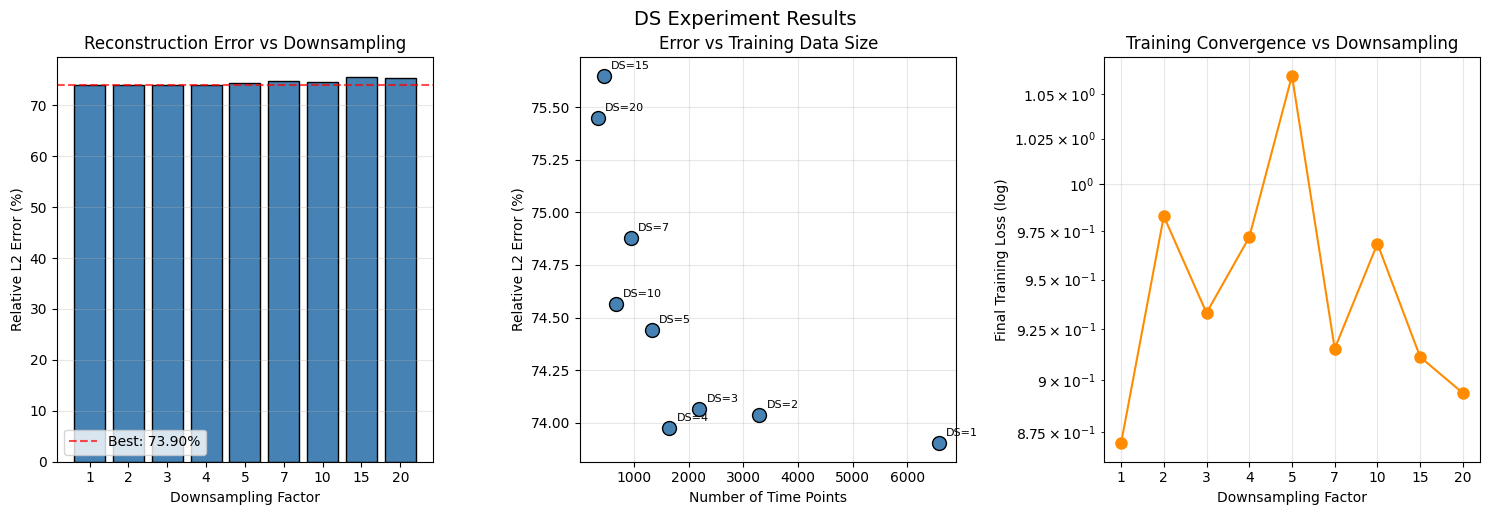


DS    Time Pts    Rel L2 Err (%)    Rank    
------------------------------------------------------------
1     6586        73.90             1        ← BEST
4     1647        73.97             2       
2     3293        74.04             3       
3     2196        74.07             4       
5     1318        74.44             5       
10    659         74.57             6       
7     941         74.88             7       
20    330         75.45             8       
15    440         75.65             9       


In [15]:
# DS Experiment Results

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Relative L2 Error vs DS Factor
ax1 = axes[0]
ds_vals = [r['ds_factor'] for r in results]
rel_errs = [r['rel_error']*100 for r in results]
ax1.bar(range(len(ds_vals)), rel_errs, color='steelblue', edgecolor='black')
ax1.set_xticks(range(len(ds_vals)))
ax1.set_xticklabels(ds_vals)
ax1.set_xlabel('Downsampling Factor')
ax1.set_ylabel('Relative L2 Error (%)')
ax1.set_title('Reconstruction Error vs Downsampling')
ax1.axhline(y=min(rel_errs), color='red', linestyle='--', alpha=0.7, label=f'Best: {min(rel_errs):.2f}%')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. Number of Time Points vs Error
ax2 = axes[1]
n_pts = [r['n_time_pts'] for r in results]
ax2.scatter(n_pts, rel_errs, s=100, c='steelblue', edgecolor='black', zorder=5)
for i, ds in enumerate(ds_vals):
    ax2.annotate(f'DS={ds}', (n_pts[i], rel_errs[i]), textcoords='offset points', 
                 xytext=(5, 5), fontsize=8)
ax2.set_xlabel('Number of Time Points')
ax2.set_ylabel('Relative L2 Error (%)')
ax2.set_title('Error vs Training Data Size')
ax2.grid(True, alpha=0.3)

# 3. Final Training Loss vs DS Factor
ax3 = axes[2]
final_losses = [r['final_loss'] for r in results]
ax3.semilogy(range(len(ds_vals)), final_losses, 'o-', color='darkorange', markersize=8)
ax3.set_xticks(range(len(ds_vals)))
ax3.set_xticklabels(ds_vals)
ax3.set_xlabel('Downsampling Factor')
ax3.set_ylabel('Final Training Loss (log)')
ax3.set_title('Training Convergence vs Downsampling')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('DS Experiment Results', y=1.02, fontsize=14)
plt.savefig('reports/ds_experiment.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print(f"{'DS':<6}{'Time Pts':<12}{'Rel L2 Err (%)':<18}{'Rank':<8}")
print("-"*60)
sorted_results = sorted(results, key=lambda x: x['rel_error'])
for rank, r in enumerate(sorted_results, 1):
    marker = " ← BEST" if rank == 1 else ""
    print(f"{r['ds_factor']:<6}{r['n_time_pts']:<12}{r['rel_error']*100:<18.2f}{rank:<8}{marker}")
print("="*60)

In [16]:
# Initial condition: |U|^2 at t = t[0]
sq0 = square_field[0]  # (p,)
sq0_tensor = torch.tensor(sq0, dtype=torch.float32)
print(f"Initial |U|^2 field sq0 shape: {sq0.shape}")
print(f"  min: {sq0.min():.4e}, max: {sq0.max():.4e}, mean: {sq0.mean():.4e}")

Initial |U|^2 field sq0 shape: (3333,)
  min: 4.5457e-07, max: 2.9455e-02, mean: 3.0550e-03


In [17]:
t_min = t_min_data
t_max = t_max_data
x_min = x_min_data
x_max = x_max_data
print(f"Coordinate ranges: t=[{t_min:.2f}, {t_max:.2f}], x=[{x_min:.2f}, {x_max:.2f}]")

Coordinate ranges: t=[200.19, 1727.91], x=[150.15, 649.95]


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

N_samples = (Nt-1) * p
print(f"Total samples: {N_samples} = {Nt-1} time steps × {p} spatial points")

def sample_batch(batch_size):
    # uniformly sample (n, j) where n is time index, j is spatial index
    idx = torch.randint(0, N_samples, (batch_size,), device=device)
    n_idx = idx // p  # time step index
    j_idx = idx % p   # spatial point index

    # Branch input: normalized |U|^2 field at time n
    Ub = branch_inputs_t[n_idx]            # (B, p)
    
    # Trunk input: normalized (t, x) coordinates
    coords = trunk_coords_t[n_idx, j_idx]  # (B, 2)
    
    # Target: normalized |U|^2 at time n+1, spatial point j
    y = targets_t[n_idx, j_idx]            # (B,) scalar target

    return Ub, coords, y

Ub_test, coords_test, y_test = sample_batch(16)
print(f"\nSample batch test:")
print(f"  Ub shape: {Ub_test.shape}, range: [{Ub_test.min().item():.3f}, {Ub_test.max().item():.3f}]")
print(f"  coords shape: {coords_test.shape}, range: [{coords_test.min().item():.3f}, {coords_test.max().item():.3f}]")
print(f"  y shape: {y_test.shape}, range: [{y_test.min().item():.3f}, {y_test.max().item():.3f}]")

Using device: cuda
Total samples: 21947805 = 6585 time steps × 3333 spatial points

Sample batch test:
  Ub shape: torch.Size([16, 3333]), range: [-0.869, 10.205]
  coords shape: torch.Size([16, 2]), range: [0.029, 0.955]
  y shape: torch.Size([16]), range: [-0.836, 1.770]


Model created with q=50 modes, q_ff=64 Fourier features
  Branch input dim: 3333
  Trunk Fourier: A1, A2 shape = (15, 2)
  Branch Fourier: B1, B2 shape = (64, 3333)
  Total parameters: 565,281

Training for 2000 epochs with batch size 4096...
Epoch    0 | Train Loss: 7.212015e-01 | Test Loss: 6.627325e-01
Epoch  200 | Train Loss: 6.238284e-01 | Test Loss: 6.234719e-01
Epoch  400 | Train Loss: 6.430960e-01 | Test Loss: 6.215317e-01
Epoch  600 | Train Loss: 5.966175e-01 | Test Loss: 6.194395e-01
Epoch  800 | Train Loss: 6.259599e-01 | Test Loss: 6.179173e-01
Epoch 1000 | Train Loss: 5.986049e-01 | Test Loss: 6.163462e-01
Epoch 1200 | Train Loss: 6.140943e-01 | Test Loss: 6.170315e-01
Epoch 1400 | Train Loss: 6.557792e-01 | Test Loss: 6.147048e-01
Epoch 1600 | Train Loss: 6.270765e-01 | Test Loss: 6.126524e-01
Epoch 1800 | Train Loss: 6.087894e-01 | Test Loss: 6.117480e-01

Final train loss: 6.194220e-01
Final test loss:  6.123990e-01


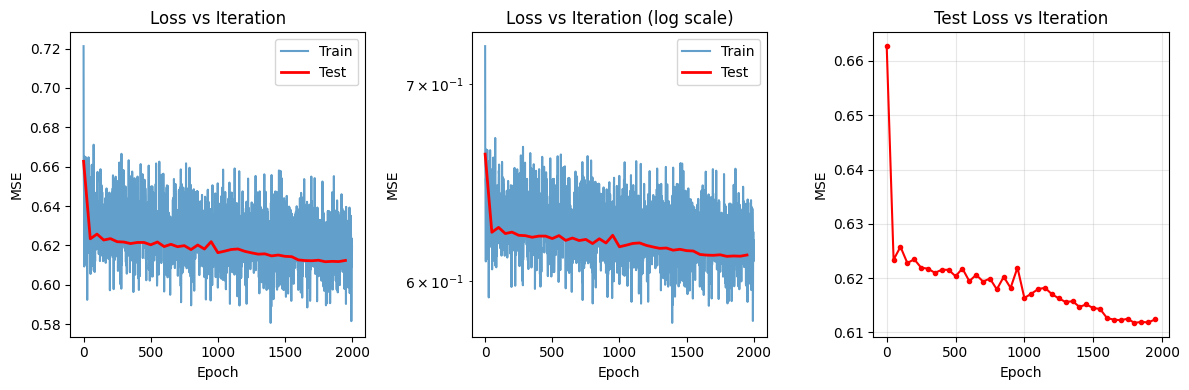

In [19]:
q = 50  
q_ff = 64 

branch = BranchNet(p, q, hidden=256, q_ff=q_ff).to(device)
trunk  = TrunkNet(q, input_dim=2, mapping_size=15).to(device)
# Full model
model = DeepONet(branch, trunk).to(device)

# Count parameters
n_params = sum(par.numel() for par in model.parameters())
print(f"Model created with q={q} modes, q_ff={q_ff} Fourier features")
print(f"  Branch input dim: {p}")
print(f"  Trunk Fourier: A1, A2 shape = (15, 2)")
print(f"  Branch Fourier: B1, B2 shape = ({q_ff}, {p})")
print(f"  Total parameters: {n_params:,}")

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Use test set from checkerboard split
test_sq_field = np.abs(U_test)**2
test_sq_norm = (test_sq_field - sq_input_mean) / sq_input_std
test_t_norm = (t_test - t_min) / (t_max - t_min)
test_x_norm = (x_test - x_min) / (x_max - x_min)

# For test loss, we need branch inputs at corresponding time indices
# Sample a fixed subset for consistent test evaluation
np.random.seed(123)
test_subset_idx = np.random.choice(len(t_test), size=min(5000, len(t_test)), replace=False)

# Training
epochs = 2000
batch_size = 4096
eval_interval = 50 

model.train()
train_loss_history = []
test_loss_history = []
test_epochs = []

print(f"\nTraining for {epochs} epochs with batch size {batch_size}...")

for epoch in range(epochs):
    Ub, coords, y = sample_batch(batch_size)

    optimizer.zero_grad()
    
    pred = model(Ub, coords)  # (B, 1)
    
    # MAE loss (L1) on normalized targets
    loss = torch.mean(torch.abs(pred.squeeze() - y))
    
    loss.backward()
    optimizer.step()
    
    train_loss_history.append(loss.item())

    if epoch % eval_interval == 0:
        model.eval()
        with torch.no_grad():
            # Compute test loss on held-out test points
            test_coords = np.stack([test_t_norm[test_subset_idx], 
                                    test_x_norm[test_subset_idx]], axis=1)
            test_coords_t = torch.tensor(test_coords, dtype=torch.float32, device=device)
            test_y = torch.tensor(test_sq_norm[test_subset_idx], dtype=torch.float32, device=device)
            
            # sq0 as branch input for test predictions
            sq0_norm = (sq0 - sq_input_mean) / sq_input_std
            sq0_norm_t = torch.tensor(sq0_norm, dtype=torch.float32, device=device).unsqueeze(0)
            
            b_out = model.branch(sq0_norm_t)  # (1, q)
            t_out = model.trunk(test_coords_t)  # (N, q)
            test_pred = torch.sum(b_out * t_out, dim=1) + model.bias.squeeze()
            
            test_loss = torch.mean(torch.abs(test_pred - test_y)).item()
            test_loss_history.append(test_loss)
            test_epochs.append(epoch)
        model.train()

    if epoch % 200 == 0:
        with torch.no_grad():
            pred_vals = pred.squeeze()
            print(f"Epoch {epoch:4d} | Train Loss: {loss.item():.6e} | Test Loss: {test_loss_history[-1]:.6e}")

print(f"\nFinal train loss: {train_loss_history[-1]:.6e}")
print(f"Final test loss:  {test_loss_history[-1]:.6e}")

# Plot training and test curves
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(train_loss_history, label='Train', alpha=0.7)
plt.plot(test_epochs, test_loss_history, 'r-', label='Test', linewidth=2)
plt.title("Loss vs Iteration")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

plt.subplot(1,3,2)
plt.semilogy(train_loss_history, label='Train', alpha=0.7)
plt.semilogy(test_epochs, test_loss_history, 'r-', label='Test', linewidth=2)
plt.title("Loss vs Iteration (log scale)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

plt.subplot(1,3,3)
plt.plot(test_epochs, test_loss_history, 'r-o', markersize=3, label='Test')
plt.title("Test Loss vs Iteration")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
def predict_square_field(model, sq_input, t_query, x_query, device=device):
    """
    Predict |U|^2 at query points given an input square field.
    
    Args:
        model: trained DeepONet
        sq_input: (p,) numpy array - |U|^2 field at input time (RAW, unnormalized)
        t_query, x_query: numpy arrays - query coordinates (RAW, unnormalized)
    
    Returns:
        pred: (N,) numpy array - Predicted |U|^2 at query points (RAW, denormalized)
    """
    # 1. Normalize input |U|^2 field
    sq_norm = (sq_input - sq_input_mean) / sq_input_std
    sq_norm_t = torch.tensor(sq_norm, dtype=torch.float32, device=device)
    
    # 2. Normalize coordinates
    coords = np.stack([t_query, x_query], axis=1)
    coords[:, 0] = (coords[:, 0] - t_min) / (t_max - t_min)
    coords[:, 1] = (coords[:, 1] - x_min) / (x_max - x_min)
    coords_t = torch.tensor(coords, dtype=torch.float32, device=device)

    model.eval()
    with torch.no_grad():
        # Branch: compute once for all query points
        b_out = model.branch(sq_norm_t.unsqueeze(0))  # (1, q)
        
        # Trunk: compute for all query points
        t_out = model.trunk(coords_t)  # (N, q)
        
        # DeepONet output: inner product + bias
        out = torch.sum(b_out * t_out, dim=1, keepdim=True) + model.bias
        pred_norm = out.squeeze().cpu().numpy()

    # 3. Denormalize prediction
    pred = pred_norm * sq_target_std + sq_target_mean
    
    return pred  # (N,) - |U|^2 in physical units

print("predict_square_field function defined")

predict_square_field function defined


Prediction stats: min=2.6282e-04, max=3.9083e-03, mean=1.9298e-03
True stats:       min=1.9089e-07, max=2.9877e-02, mean=2.9882e-03


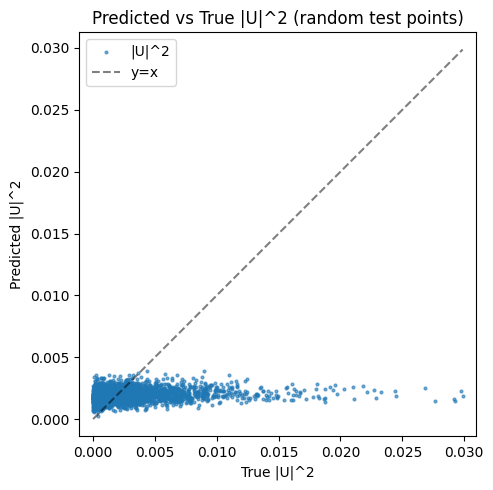

In [21]:
# Test on random points
np.random.seed(42)
idx = np.random.choice(len(t_test), size=3000, replace=False)

# Predict |U|^2
pred_sq = predict_square_field(
    model, sq0,  # Use initial |U|^2 field
    t_test[idx], x_test[idx]
)

# True |U|^2
true_sq = np.abs(U_test[idx])**2

print(f"Prediction stats: min={pred_sq.min():.4e}, max={pred_sq.max():.4e}, mean={pred_sq.mean():.4e}")
print(f"True stats:       min={true_sq.min():.4e}, max={true_sq.max():.4e}, mean={true_sq.mean():.4e}")

plt.figure(figsize=(5,5))
plt.scatter(true_sq, pred_sq, s=4, alpha=0.6, label="|U|^2")

all_vals = np.concatenate([true_sq, pred_sq])
lims = [all_vals.min(), all_vals.max()]
plt.plot(lims, lims, 'k--', alpha=0.5, label="y=x")

plt.xlabel("True |U|^2")
plt.ylabel("Predicted |U|^2")
plt.legend()
plt.title("Predicted vs True |U|^2 (random test points)")
plt.axis("equal")
plt.tight_layout()
plt.show()

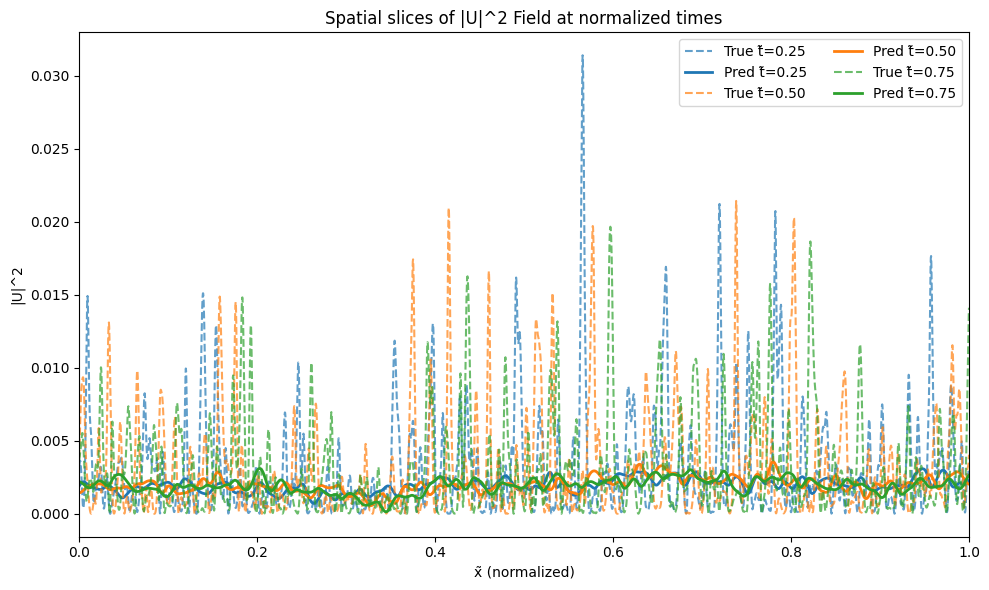

In [22]:
# Spatial slices at fixed times (using initial |U|^2 as branch input)

t_slices_norm = [0.25, 0.5, 0.75]  # Normalized time values in [0,1]

# Normalized x coordinates
x_norm = (x - x_min) / (x_max - x_min)

plt.figure(figsize=(10,6))

for t0_norm in t_slices_norm:
    # Convert normalized time to physical time for prediction function
    t0_phys = t0_norm * (t_max - t_min) + t_min
    t_query = np.full_like(x, t0_phys)
    pred_sq = predict_square_field(model, sq0, t_query, x)

    # Ground truth |U|^2 at this time
    true_idx = np.argmin(np.abs(t - t0_phys))
    true_sq = np.abs(U[true_idx])**2

    # Plot comparison with normalized x
    line = plt.plot(x_norm, true_sq, '--', alpha=0.7, label=f"True t̃={t0_norm:.2f}")
    color = line[0].get_color()
    plt.plot(x_norm, pred_sq, '-', color=color, linewidth=2, label=f"Pred t̃={t0_norm:.2f}")

plt.xlabel("x̃ (normalized)")
plt.ylabel("|U|^2")
plt.title("Spatial slices of |U|^2 Field at normalized times")
plt.legend(ncol=2)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

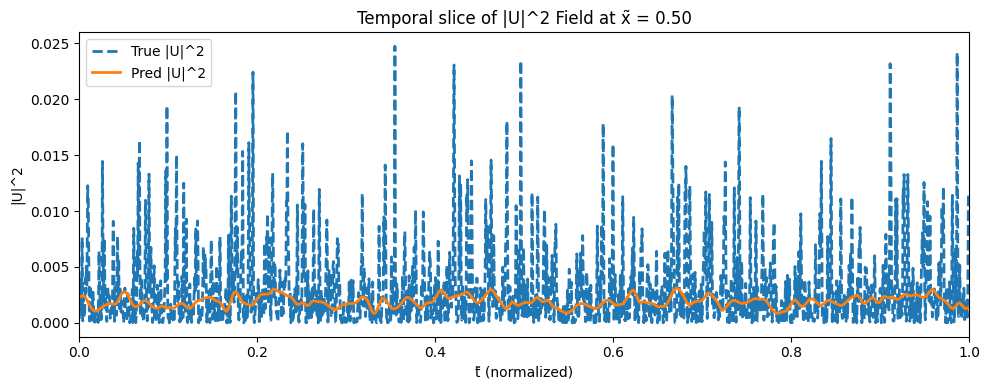

In [23]:
x0_norm = 0.5 
x0_phys = x0_norm * (x_max - x_min) + x_min

# Normalized t coordinates
t_norm = (t - t_min) / (t_max - t_min)

x_query = np.full_like(t, x0_phys)
pred_sq = predict_square_field(model, sq0, t, x_query)

# Ground truth
x_idx = np.argmin(np.abs(x - x0_phys))
true_sq = np.abs(U[:, x_idx])**2

plt.figure(figsize=(10,4))
plt.plot(t_norm, true_sq, '--', label="True |U|^2", linewidth=2)
plt.plot(t_norm, pred_sq, '-', label="Pred |U|^2", linewidth=2)
plt.xlabel("t̃ (normalized)")
plt.ylabel("|U|^2")
plt.title(f"Temporal slice of |U|^2 Field at x̃ = {x0_norm:.2f}")
plt.xlim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

True |U|^2 range:  [7.0716e-08, 6.4337e-02]
Pred |U|^2 range:  [3.4765e-05, 4.0973e-03]
Mean relative error: 6.3325


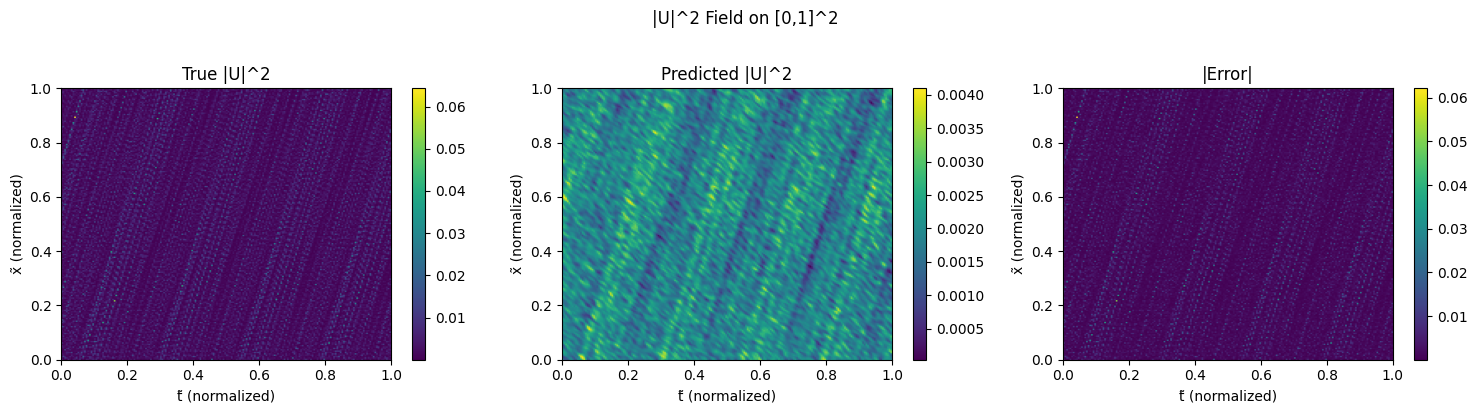

In [24]:
# Full spatiotemporal comparison on normalized [0,1]^2 domain
Nt_plot = 200
Nx_plot = 200

t_norm_sub = np.linspace(0, 1, Nt_plot)
x_norm_sub = np.linspace(0, 1, Nx_plot)
t_sub = t_norm_sub * (t_max - t_min) + t_min
x_sub = x_norm_sub * (x_max - x_min) + x_min

Tg, Xg = np.meshgrid(t_sub, x_sub, indexing="ij")
tq = Tg.flatten()
xq = Xg.flatten()

# Predict |U|^2 on grid
pred_sq_flat = predict_square_field(model, sq0, tq, xq)
sq_pred = pred_sq_flat.reshape(Nt_plot, Nx_plot)

# ground truth 

sq_true = np.zeros_like(sq_pred)
for i, ti in enumerate(t_sub):
    ti_idx = np.argmin(np.abs(t - ti))
    for j, xj in enumerate(x_sub):
        xj_idx = np.argmin(np.abs(x - xj))
        sq_true[i, j] = np.abs(U[ti_idx, xj_idx])**2

print(f"True |U|^2 range:  [{sq_true.min():.4e}, {sq_true.max():.4e}]")
print(f"Pred |U|^2 range:  [{sq_pred.min():.4e}, {sq_pred.max():.4e}]")

rel_error = np.abs(sq_true - sq_pred) / (np.abs(sq_true) + 1e-10)
print(f"Mean relative error: {rel_error.mean():.4f}")

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(sq_true.T, aspect="auto", origin="lower",
           extent=[0, 1, 0, 1])
plt.title("True |U|^2")
plt.xlabel("t̃ (normalized)")
plt.ylabel("x̃ (normalized)")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(sq_pred.T, aspect="auto", origin="lower",
           extent=[0, 1, 0, 1])
plt.title("Predicted |U|^2")
plt.xlabel("t̃ (normalized)")
plt.ylabel("x̃ (normalized)")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.abs(sq_true - sq_pred).T, aspect="auto", origin="lower",
           extent=[0, 1, 0, 1])
plt.title("|Error|")
plt.xlabel("t̃ (normalized)")
plt.ylabel("x̃ (normalized)")
plt.colorbar()

plt.suptitle("|U|^2 Field on [0,1]^2", y=1.02)
plt.tight_layout()
plt.show()

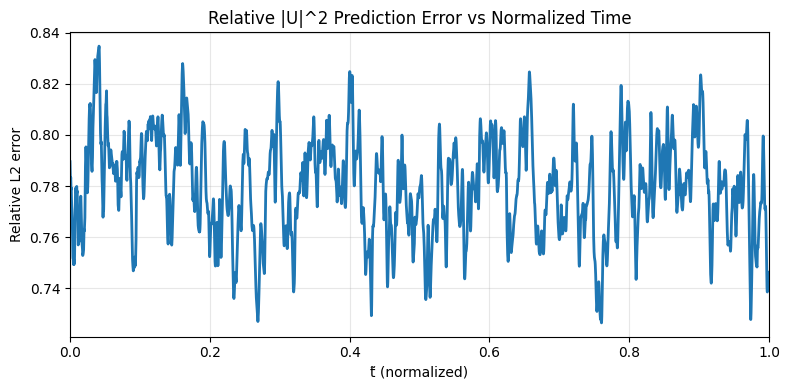

Mean relative error: 0.7796
Max relative error:  0.8347


In [25]:
t_norm = (t - t_min) / (t_max - t_min)
rel_err = []

for i in range(len(t)):
    # Predict |U|^2 at time t[i] for all x
    pred_sq = predict_square_field(model, sq0, np.full_like(x, t[i]), x)
    
    # True |U|^2
    true_sq = np.abs(U[i])**2
    
    # Relative L2 error
    num = np.linalg.norm(pred_sq - true_sq)
    den = np.linalg.norm(true_sq) + 1e-10
    rel_err.append(num / den)

plt.figure(figsize=(8, 4))
plt.plot(t_norm, rel_err, linewidth=2)
plt.xlabel("t̃ (normalized)")
plt.ylabel("Relative L2 error")
plt.title("Relative |U|^2 Prediction Error vs Normalized Time")
plt.xlim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Mean relative error: {np.mean(rel_err):.4f}")
print(f"Max relative error:  {np.max(rel_err):.4f}")

In [26]:
print("FOURIER FEATURES ANALYSIS (Separate A1, A2, B1, B2 matrices)")

A1 = model.trunk.ff.A1  # Trunk sin
A2 = model.trunk.ff.A2  # Trunk cos
B1 = model.branch.ff.B1  # Branch sin
B2 = model.branch.ff.B2  # Branch cos

print("\nDIMENSIONS:")
print(f"   Trunk A1 (sin): {A1.shape}")
print(f"   Trunk A2 (cos): {A2.shape}")
print(f"   Branch B1 (sin): {B1.shape}")
print(f"   Branch B2 (cos): {B2.shape}")


print("\nTRAINABILITY CHECK:")
print(f"   A1.requires_grad = {A1.requires_grad}")
print(f"   A2.requires_grad = {A2.requires_grad}")
print(f"   B1.requires_grad = {B1.requires_grad}")
print(f"   B2.requires_grad = {B2.requires_grad}")

print("\nCURRENT MATRIX STATISTICS:")
for name, mat in [("A1", A1), ("A2", A2), ("B1", B1), ("B2", B2)]:
    print(f"   {name}: mean={mat.data.mean().item():.4f}, std={mat.data.std().item():.4f}, "
          f"range=[{mat.data.min().item():.4f}, {mat.data.max().item():.4f}]")

print("\nEVOLUTION TEST (10 training steps):")
A1_before = A1.data.clone()
A2_before = A2.data.clone()
B1_before = B1.data.clone()
B2_before = B2.data.clone()

model.train()
for _ in range(10):
    Ub, coords, y = sample_batch(batch_size)
    optimizer.zero_grad()
    pred = model(Ub, coords)
    loss = torch.mean((pred.squeeze() - y)**2)
    loss.backward()
    optimizer.step()

# Compute changes
changes = {
    "A1": (A1.data - A1_before).abs(),
    "A2": (A2.data - A2_before).abs(),
    "B1": (B1.data - B1_before).abs(),
    "B2": (B2.data - B2_before).abs()
}

print("Changes after 10 steps:")
all_evolving = True
for name, delta in changes.items():
    mean_change = delta.mean().item()
    max_change = delta.max().item()
    evolving = max_change > 1e-10
    status = "1" if evolving else "0"
    print(f"   {status} {name}: mean={mean_change:.2e}, max={max_change:.2e}")
    all_evolving = all_evolving and evolving

if all_evolving:
    print("training")
else:
    print("no evolution")


FOURIER FEATURES ANALYSIS (Separate A1, A2, B1, B2 matrices)

DIMENSIONS:
   Trunk A1 (sin): torch.Size([15, 2])
   Trunk A2 (cos): torch.Size([15, 2])
   Branch B1 (sin): torch.Size([64, 3333])
   Branch B2 (cos): torch.Size([64, 3333])

TRAINABILITY CHECK:
   A1.requires_grad = True
   A2.requires_grad = True
   B1.requires_grad = True
   B2.requires_grad = True

CURRENT MATRIX STATISTICS:
   A1: mean=15.9810, std=7.1562, range=[5.3418, 36.9353]
   A2: mean=13.3300, std=4.5014, range=[5.5633, 22.7790]
   B1: mean=0.5799, std=0.0698, range=[0.3711, 0.9931]
   B2: mean=0.5797, std=0.0698, range=[0.3588, 0.9820]

EVOLUTION TEST (10 training steps):
Changes after 10 steps:
   1 A1: mean=3.82e-03, max=9.96e-03
   1 A2: mean=3.80e-03, max=9.48e-03
   1 B1: mean=2.41e-03, max=1.89e-02
   1 B2: mean=2.55e-03, max=1.74e-02
training
